In [1]:
import numpy as np
from get_border_cases import get_border_cases
import matplotlib.pyplot as plt

In [2]:
n = 17
N = n - 1
inner_n = n - 2
border_cases = get_border_cases(N)
params = np.ones(inner_n ** 2)



In [3]:
'''
    Computes the value of a game.
    game is 2x2 matrix.
'''
def get_value(game):
    return (game[0, 0] * game[1, 1] - game[0, 1] * game[1, 0]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Compute optimal strategy for player 1.
'''
def get_p1(game):
    return (game[1, 1] - game[1, 0]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Compute optimal strategy for player 2.
'''
def get_q1(game):
    return (game[1, 1] - game[0, 1]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Converts global index to inner index.
    index - index to convert.
    inner_n - inner dimension (without borders).
    global_n - outer dimension (with borders).
'''
def inner_n_to_global_N(index, inner_n, global_n):
    row = index // inner_n
    col = index % inner_n
    global_index = (row + 1) * global_n + (col + 1)
    return global_index

def global_N_to_inner_n(index, inner_n, global_n):
    row = index // global_n
    col = index % global_n

    if row < 1 or col < 1 or row > global_n - 2 or col > global_n - 2:
        raise ValueError("Index should match an inner node.")
    inner_index = (row - 1) * inner_n + (col - 1)
    return inner_index

'''
    Checks if a game matrix has saddles.
'''
def check_for_saddle(game):
    '''
    saddles = []
    strategies = []
    for i in range(2):
        for j in range(2):
            if np.isclose(game[i, j], np.min(game[i]), rtol=1e-8, atol=1e-8) and \
                np.isclose(game[i, j], np.max(game[:, j]), rtol=1e-8, atol=1e-8):
                saddles.append(game[i, j])
                strategies.append((i, j))

    #print(f"From saddle function saddles: {saddles}")
    #print(f"From saddle function strategies: {strategies}")
    if len(saddles) > 1:
        if np.sum(np.isclose(np.array(saddles) - saddles[0], 0)):
            return saddles[0], strategies[0]
        else:
            raise ValueError("Saddle values don't match")
    elif len(saddles) == 1:
        return saddles[0], strategies[0]
    else:
        return 'N'
    '''
    maximin = np.max(np.min(game, axis=1))
    minimax = np.min(np.max(game, axis=0))
    res = 'N'
    if np.isclose(maximin, minimax, rtol=1e-8, atol=1e-8):
        res = maximin
        index = next(i for i, _ in enumerate(game.flatten()) if np.isclose(_, res, rtol=1e-8, atol=1e-8)) 
        return res, (index // 2, index % 2)
    return 'N'
    
def get_game(index, w):
    game = np.zeros((2, 2))
    game[0, 0] = compute_a11(index, w)
    game[0, 1] = compute_a12(index, w)
    game[1, 0] = compute_a21(index, w)
    game[1, 1] = compute_a22(index, w)
    return game

# Up
def compute_a11(index, w):
    if (index - n) in border_cases:
        a11 = 1
    else:
        a11 = w[global_N_to_inner_n(index - n, inner_n, n)] + 1
    return a11
    
# Down
def compute_a21(index, w):
    if (index + n) in border_cases:
        a12 = 1
    else:
        a12 = w[global_N_to_inner_n(index + n, inner_n, n)] + 1
    return a12

# Right
def compute_a12(index, w):
    if (index + 1) in border_cases:
        a21 = 1
    else:
        a21 = w[global_N_to_inner_n(index + 1, inner_n, n)] + 1
    return a21

# Left
def compute_a22(index, w):
    if (index - 1) in border_cases:
        a22 = 1
    else:
        a22 = w[global_N_to_inner_n(index - 1, inner_n, n)] + 1
    return a22
    

'''
    Number of values in w should match number of equations.
'''
def prepare_equations(w):
    eqs = np.zeros(len(w))
    p1s = []
    q1s = []
    for i in range(len(w)):
        index = inner_n_to_global_N(i, inner_n, n)
        game_mx = get_game(index, w)
        saddle = check_for_saddle(game_mx)
        if saddle == "N":
            v = get_value(game_mx)
            p1 = get_p1(game_mx)
            q1 = get_q1(game_mx)
        else:
            v, (p1, q1) = saddle

        p1s.append(p1)
        q1s.append(q1)
        eqs[i] = w[i] - v

    return tuple(eqs)

### Кто есть кто?

#### Кто Игрок 1, а кто Игрок 2 определяется через элементы матрицы игры a12 и a21.

#### Если a12 соответствует движению вправо, то Игрок 1 (выбирающий строки) - Центр, а Игрок 2 (выбирающий столбцы) - Граница. В таком случае a21 соответствует движению вниз.
#### Если a12 соответствует движению вниз, то Игрок 1 (выбирающий строки) - Граница, а Игрок 2 (выбирающий столбцы) - Центр. В таком случае a12 соответствует движению врпаво.

#### Сейчас a12 соответствует движению вправо.

In [4]:
from scipy.optimize import fsolve

starting_params = np.random.random(inner_n ** 2)
#starting_params = np.ones(inner_n ** 2) * 3
w_new = fsolve(prepare_equations, tuple(starting_params))

g:\Anaconda3\envs\mlunn2\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [5]:
w_new

array([ 0.7619493 ,  1.0422295 ,  0.03826009,  1.07832707,  0.11075017,
        0.76122861,  1.57471034,  0.74531526,  1.71311962,  0.32124764,
        1.60100473,  1.30054731,  0.35388034,  0.39685628,  1.30229582,
       -0.00297406,  0.05961753, -0.09951952,  1.01377397,  0.0366594 ,
        0.80302519,  1.72932952,  0.69818552,  1.65541892,  0.15581597,
        1.10606688,  0.54695441,  0.18305176,  0.28758291,  1.33513176,
        0.3589739 ,  1.11784937, -0.00952694,  1.08512083,  0.12155964,
        0.88093572,  1.6515738 ,  0.65279723,  1.495224  ,  0.32046867,
        1.61310528,  0.71155997,  0.33880635,  0.38477846,  1.35563138,
        0.31968842,  1.28727878,  0.02620678,  1.17648179,  0.1360821 ,
        1.49934958,  2.10006041,  0.80114763,  1.78529166,  0.23648943,
        0.32615618,  0.24385227,  0.28345271,  0.22427144,  1.3115496 ,
        0.35071743,  1.31809881,  0.00319234,  0.89379053,  0.11108329,
        0.48854895,  0.41350448,  0.38651794,  0.43548491,  0.36

In [6]:
p1s = []
q1s = []
vs = []
for i in range(inner_n ** 2):
    index = inner_n_to_global_N(i, inner_n, n)
    game_mx = get_game(index, w_new)
    saddle = check_for_saddle(game_mx)


    print(f"index = {index}")
    print(f"game_mx:\n {game_mx}")
    print(f"saddle = {saddle}")
    if saddle == "N":
        v = get_value(game_mx)
        p1 = get_p1(game_mx)
        q1 = get_q1(game_mx)
        print(f"p1 form N: {p1}")
    else:
        v, (p1, q1) = saddle

    print(f"v = {v}")
    print(f"p1 = {p1}")
    print(f"q1 = {q1}")
    p1s.append(p1)
    q1s.append(q1)
    vs.append(v)

index = 18
game_mx:
 [[1.         2.0422295 ]
 [0.99702594 1.        ]]
saddle = (1.0, (0, 0))
v = 1.0
p1 = 0
q1 = 0
index = 19
game_mx:
 [[1.         1.03826009]
 [1.05961753 1.7619493 ]]
saddle = (1.059617532322646, (1, 0))
v = 1.059617532322646
p1 = 1
q1 = 0
index = 20
game_mx:
 [[1.         2.07832707]
 [0.90048048 2.0422295 ]]
saddle = (1.0, (0, 0))
v = 1.0
p1 = 0
q1 = 0
index = 21
game_mx:
 [[1.         1.11075017]
 [2.01377397 1.03826009]]
saddle = N
p1 form N: 0.898044890162243
v = 1.1033594365711232
p1 = 0.898044890162243
q1 = 0.06673339077487235
index = 22
game_mx:
 [[1.         1.76122861]
 [1.0366594  2.07832707]]
saddle = (1.0366593986121406, (1, 0))
v = 1.0366593986121406
p1 = 1
q1 = 0
index = 23
game_mx:
 [[1.         2.57471034]
 [1.80302519 1.11075017]]
saddle = N
p1 form N: 0.30537251342067495
v = 1.5578033671553262
p1 = 0.30537251342067495
q1 = 0.6457739857117828
index = 24
game_mx:
 [[1.         1.74531526]
 [2.72932952 1.76122861]]
saddle = (1.7612286126671524, (1,

Text(0.5, 1.0, 'Probability of choosing the 1st strategy for Player 1.')

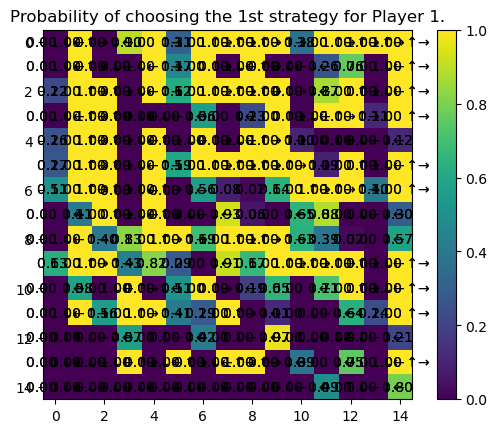

In [7]:
plt.imshow(np.reshape(p1s, newshape=(inner_n, inner_n)))
plt.colorbar()
for (j, i), label in np.ndenumerate(np.reshape(p1s, newshape=(inner_n, inner_n))):
    print_str_1 = "↑→" if np.isclose(label, 1) else ""
    print_str_2 = "↓←" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    #print(label)
plt.title("Probability of choosing the 1st strategy for Player 1.")

Text(0.5, 1.0, 'Probability of choosing the 2nd strategy for Player 1.')

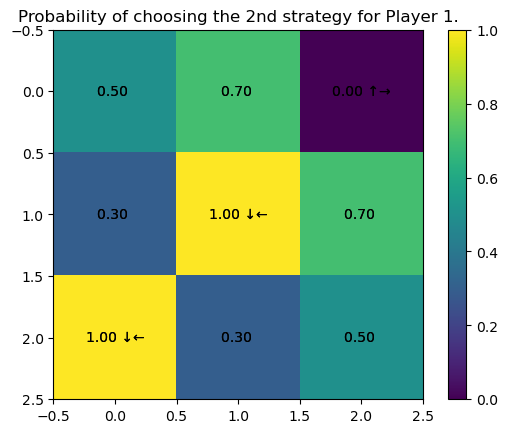

In [66]:
plt.imshow(1 - np.reshape(p1s, newshape=(inner_n, inner_n)))
plt.colorbar()
for (j, i), label in np.ndenumerate(1 - np.reshape(p1s, newshape=(inner_n, inner_n))):
    print_str_1 = "↓←" if np.isclose(label, 1) else ""
    print_str_2 = "↑→" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    #print(label)
plt.title("Probability of choosing the 2nd strategy for Player 1.")

Text(0.5, 1.0, 'Probability of choosing the 1st strategy for Player 2.')

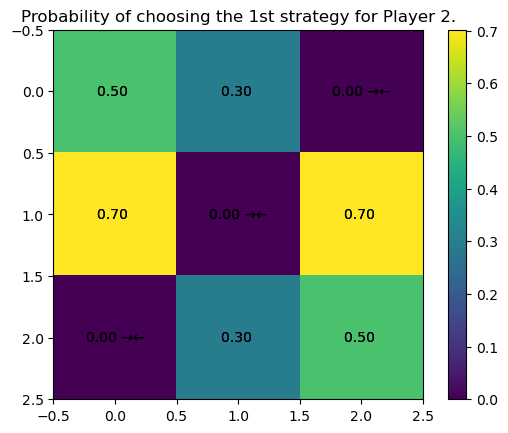

In [67]:
plt.imshow(np.reshape(q1s, newshape=(inner_n, inner_n)))
plt.colorbar()
for (j, i), label in np.ndenumerate(np.reshape(q1s, newshape=(inner_n, inner_n))):
    print_str_1 = "↑↓" if np.isclose(label, 1) else ""
    print_str_2 = "→←" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    #print(label)
plt.title("Probability of choosing the 1st strategy for Player 2.")

0.7619492979989352
1.042229497966385
0.03826008736340297
1.0783270658061113
0.11075017101162599
0.7612286126671524
1.574710339318748
0.7453152625532385
1.7131196224604177
0.32124763768554193
1.6010047258316273
1.3005473129133527
0.35388034191749557
0.3968562794647081
1.3022958240196567
-0.0029740559522129896
0.059617532322645946
-0.09951951588326358
1.0137739710702198
0.036659398612140695
0.8030251867835152
1.7293295214535729
0.6981855168837254
1.6554189213109738
0.15581597059098515
1.1060668813517545
0.5469544100642638
0.18305175979595223
0.2875829122243556
1.3351317624798213
0.35897389992749895
1.1178493693072757
-0.009526937769761098
1.085120826486551
0.1215596388287736
0.8809357230968291
1.6515737959747938
0.6527972349066632
1.4952239972928392
0.32046867104058063
1.613105280186696
0.7115599745902758
0.3388063543725403
0.38477846398869925
1.3556313778930944
0.3196884227581849
1.2872787828593215
0.026206782391048577
1.1764817858449348
0.1360820963005386
1.4993495826333445
2.100060410

Text(0.5, 1.0, 'Game value for each component')

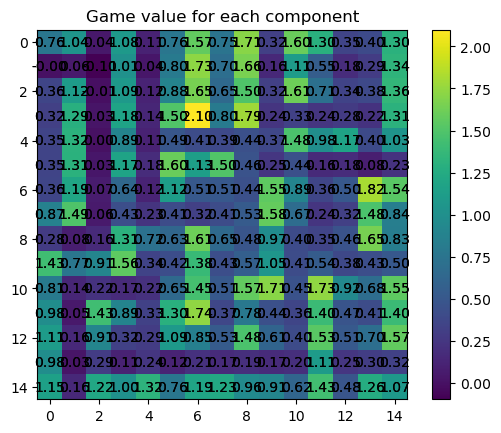

In [8]:
w_mx = np.array(w_new)
w_mx = np.reshape(w_mx, newshape=(inner_n, inner_n))

plt.imshow(w_mx)
plt.colorbar()
for (j, i), label in np.ndenumerate(w_mx):
    plt.text(i, j, f"{label:.2f}", ha='center', va='center')
    plt.text(i, j, f"{label:.2f}", ha='center', va='center')
    print(label)
plt.title("Game value for each component")